In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date

# preprocessing
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit


# plotting
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

# preprocessing
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import preprocessing

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

# save and load models
import joblib
from tensorflow.keras.models import load_model
# Models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# Evaluation
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve, auc

# save and load models
import joblib
from tensorflow.keras.models import load_model

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Dataset Link ="https://www.kaggle.com/datasets/kartik2112/fraud-detection"

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Credit_Card_Fraud_Detection/fraudTrain.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Credit_Card_Fraud_Detection/fraudTest.csv")

In [5]:
print("rows: ",df.shape[0])
print("columns: ",df.shape[1])

rows:  1296675
columns:  23


In [6]:
df.head(5)

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [7]:
df.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [8]:
def plot_featureToClass(col, classtype):
    '''
    Creates a plot of time based on the class type

    Args :
    - col: column name to plot
    - classtype: class type (fraud or non fraud)

    Output : None
    '''
    new_df = df[col].where(df['is_fraud'] == classtype)
    new_df = new_df.dropna()
    plt.plot(new_df)
    plt.show()

In [9]:
def handle_outlier(col, threshold=1.5):
    '''
    Function that gets maximum and minimum values for provided column

    Args:
        col (pandas.Series): Column name
        threshold (float): Threshold value for defining outliers

    Returns:
        tuple: The lower and upper bounds for outliers
    '''
    Q1, Q3 = col.quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower = Q1 - (threshold * IQR)
    upper = Q3 + (threshold * IQR)
    return lower, upper

In [10]:
def draw_boxplot(colname):
    '''
    Creates a boxplot for the specified column

    Args:
        colname (str): Column name

    Returns:
        None
    '''
    sns.boxplot(df[colname])
    plt.xlabel(colname)
    plt.ylabel('Value')
    plt.title(f'Boxplot of {colname}')
    plt.show()

In [11]:
def boxplot_feature_vs_class(feature,dataframe):
    '''
    Creates a boxplot for every feature vs class type

    Args: col (str) feature name

    Output : Boxplot
    '''
    sns.boxplot(x="is_fraud", y=feature, data=dataframe)
    plt.xlabel("is_fraud")
    plt.ylabel(feature)
    plt.title(f"Relationship between {feature} and is_fraud")
    plt.show()

**EDA**

Analyze distribution of the target variable

In [12]:
print('0 - NonFraud :', df['is_fraud'].value_counts()[0])
print('1 - Fraud :', df['is_fraud'].value_counts()[1])

0 - NonFraud : 1289169
1 - Fraud : 7506


In [14]:
fig = px.histogram(df, x="unix_time", y="amt", color="is_fraud", barmode="group", hover_data=df.columns, color_discrete_sequence=['#45818e','#134f5c'])

fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [15]:
fraud = df[df['is_fraud'] == 1]

**Who steals more: Men or Women?**

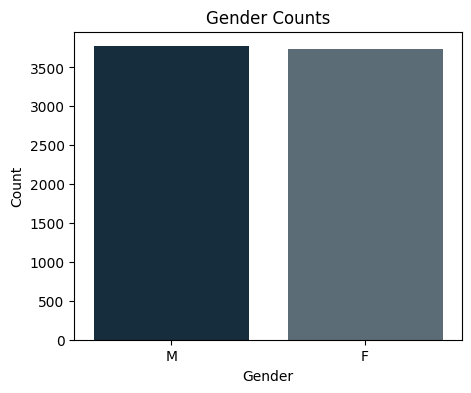

In [16]:
plt.figure(figsize=(5, 4))
sns.countplot(data=fraud, x="gender", palette=sns.color_palette(['#0E2F44', '#566D7C']))
plt.title("Gender Counts")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.show()

**Is there a link between age and fraud?**

In [17]:
fraud['dob'] = pd.to_datetime(fraud['dob'])
today = date.today()
fraud['age'] = today.year - fraud['dob'].dt.year

<ipython-input-17-88f9c894b894>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-17-88f9c894b894>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



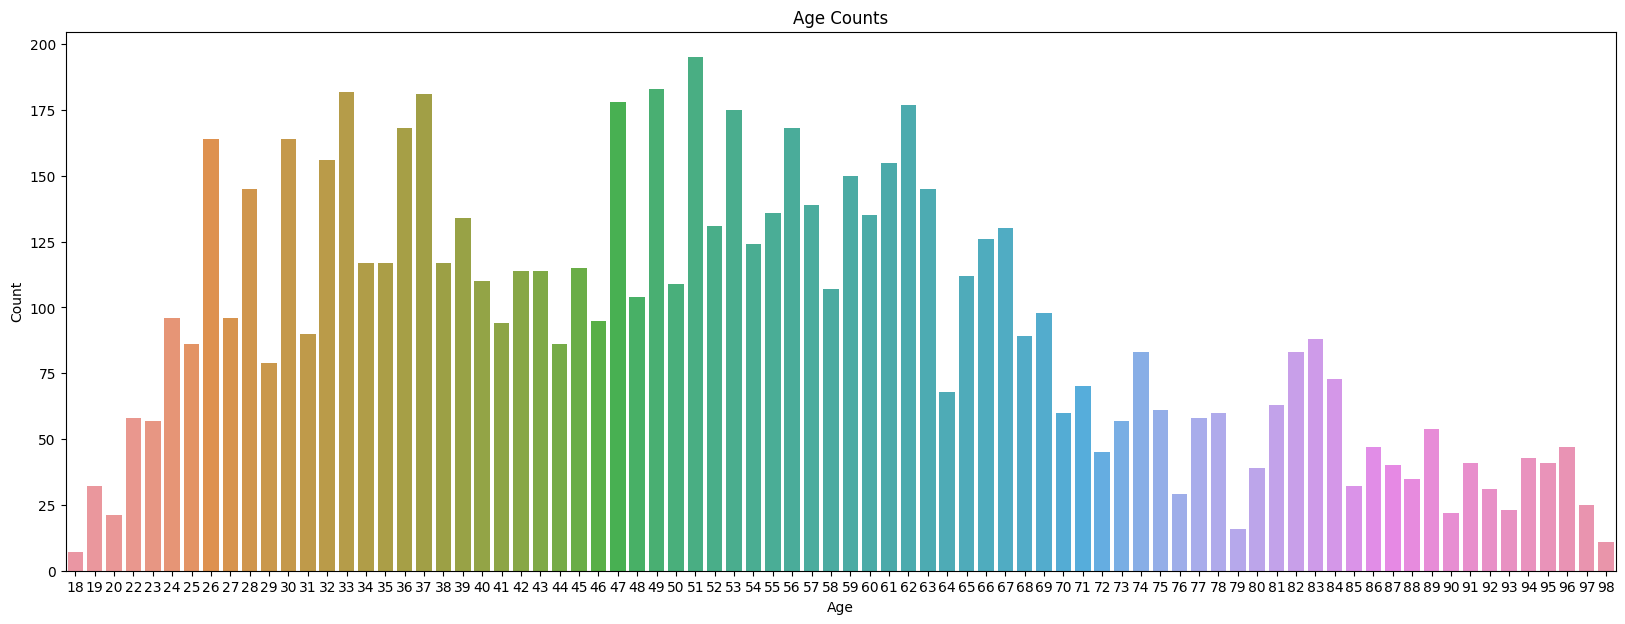

In [18]:
plt.figure(figsize=(20, 7))
sns.countplot(data=fraud, x="age")
plt.title("Age Counts")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

**Where do frauds happen the most and what gender?**

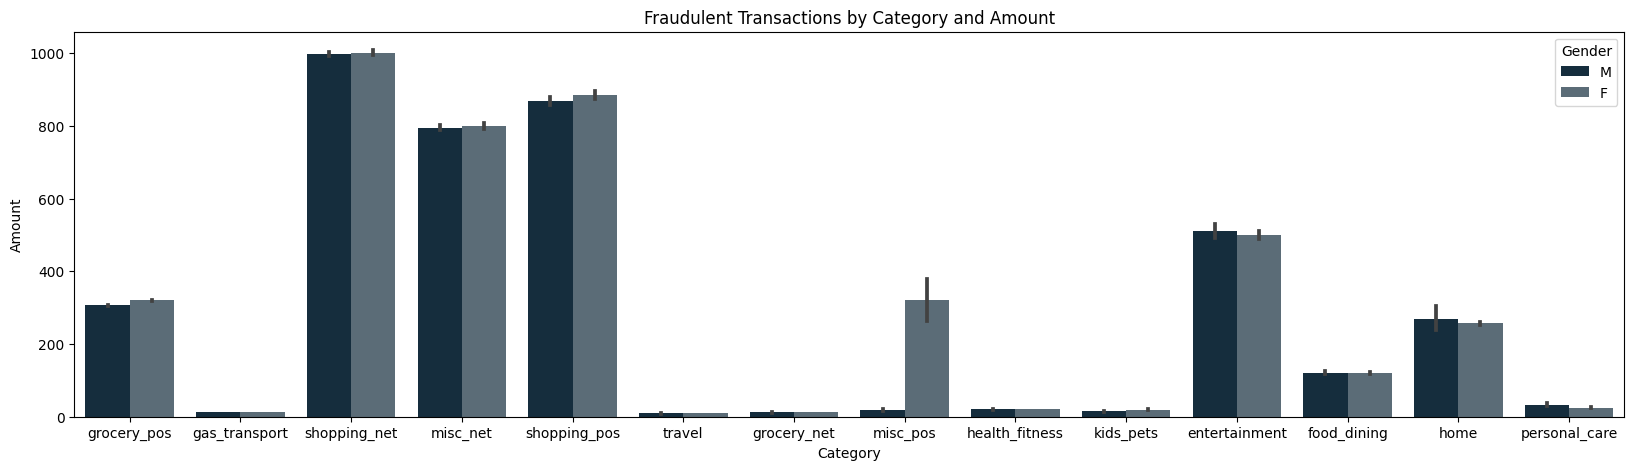

In [19]:
plt.figure(figsize=(20, 5))
sns.barplot(data=fraud, x="category", y="amt", hue="gender", palette=sns.color_palette(['#0E2F44', '#566D7C']))
plt.title("Fraudulent Transactions by Category and Amount")
plt.xlabel("Category")
plt.ylabel("Amount")
plt.legend(title="Gender")
plt.show()

**Data preparation**

In [20]:
df["trans_date_trans_time"] = pd.to_datetime(df["trans_date_trans_time"], infer_datetime_format=True)
df["dob"] = pd.to_datetime(df["dob"], infer_datetime_format=True)

In [21]:
if df.duplicated().sum() > 0:
    df.drop_duplicates(inplace=True)
    print('Duplicates dropped')
else:
    print('No Duplicates Exist')

No Duplicates Exist


**Data Encoding**

In [22]:
label_encoder = preprocessing.LabelEncoder()
for col in df.columns:
    df[col]= label_encoder.fit_transform(df[col])

**Data Scaling**

In [23]:
rob_scaler = RobustScaler()

for col in df.columns:
    if df[col].dtype =='object':
        df[col] = rob_scaler.fit_transform(df[col].values.reshape(-1,1))
    else:
        pass

**Outliers**

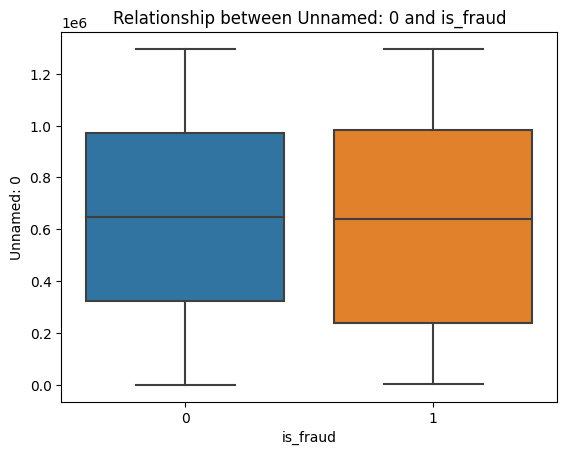

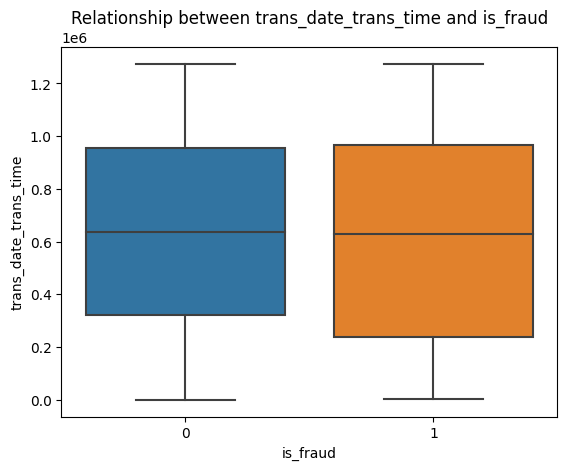

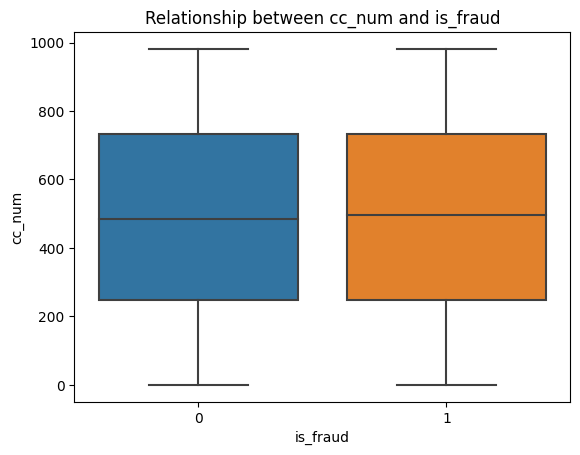

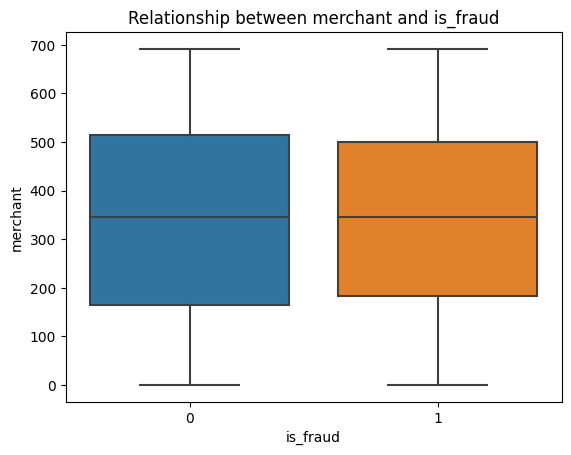

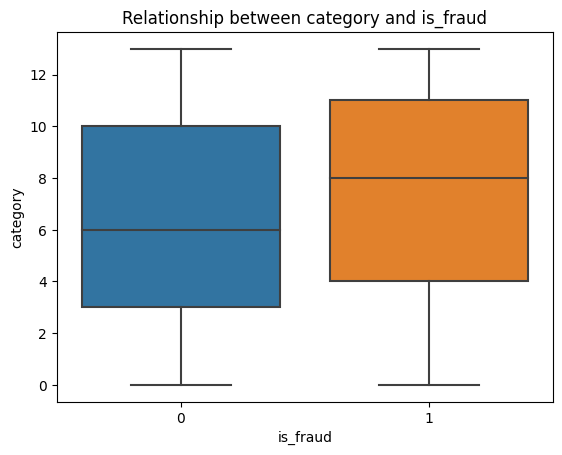

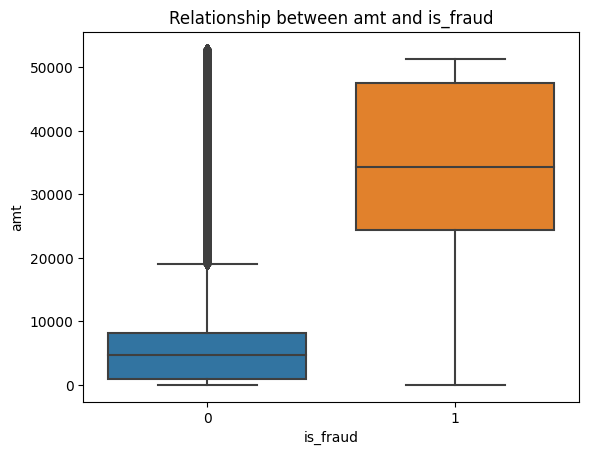

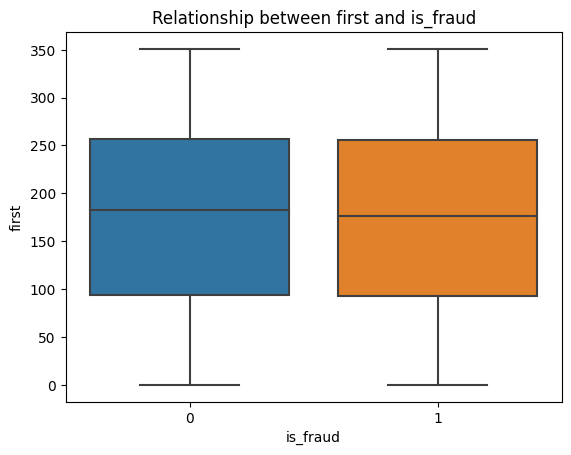

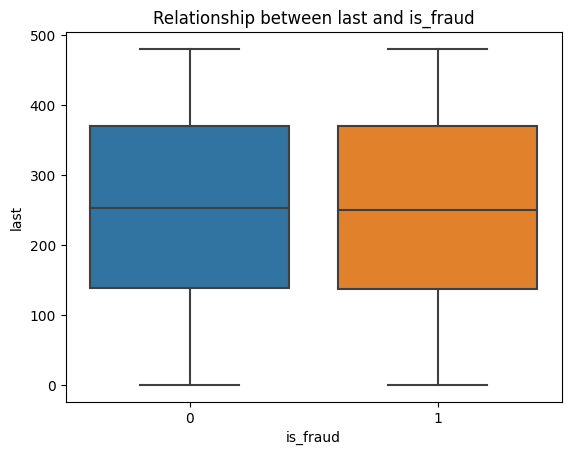

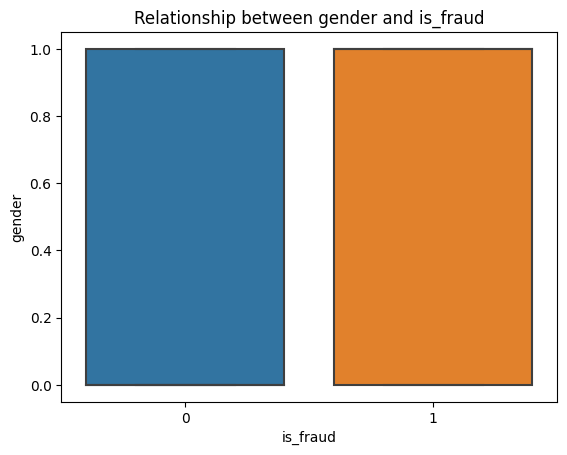

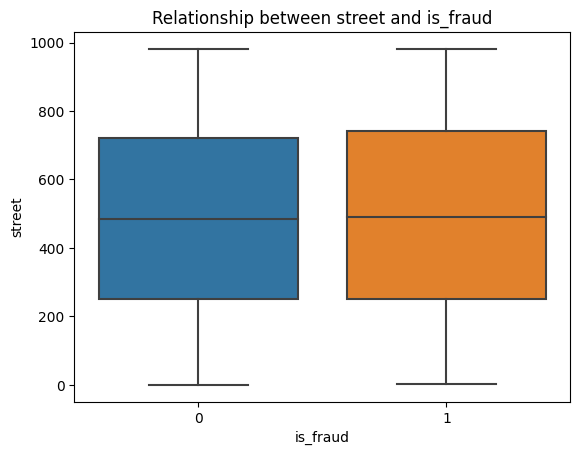

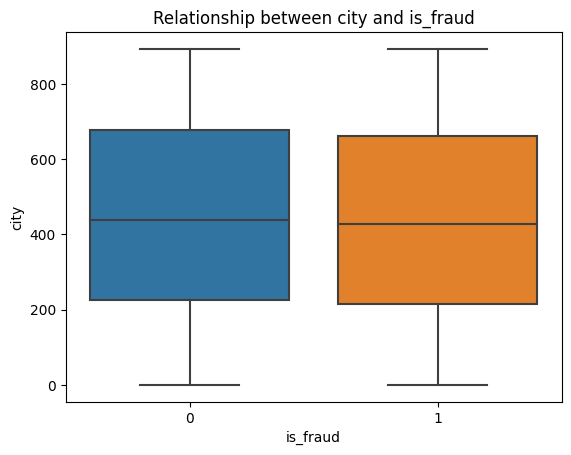

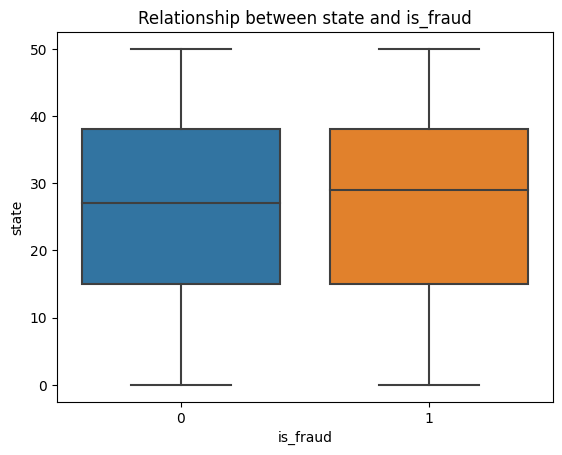

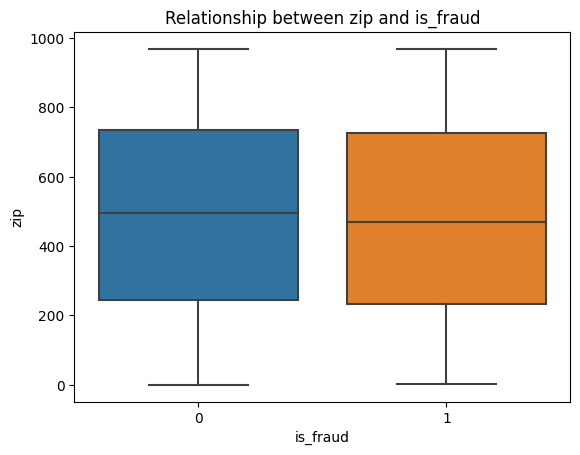

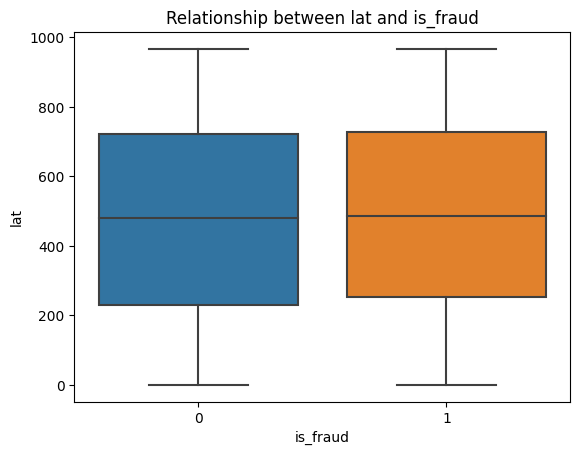

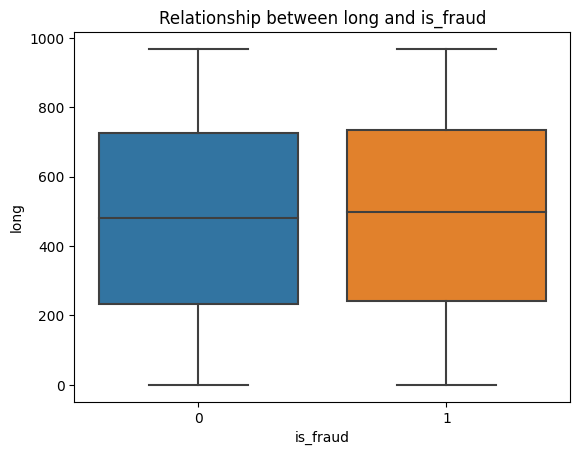

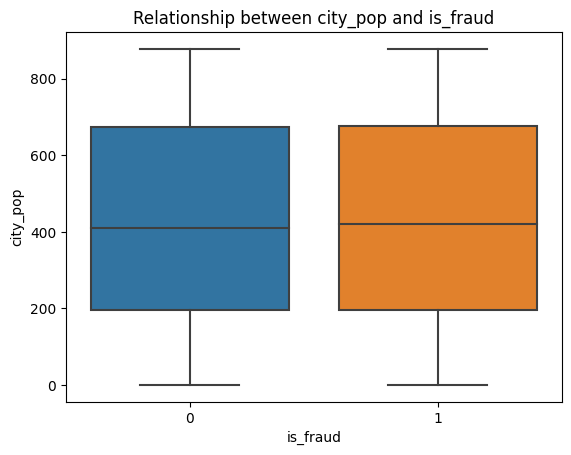

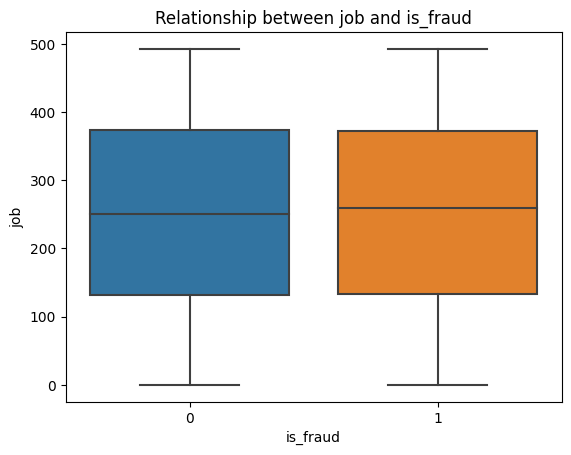

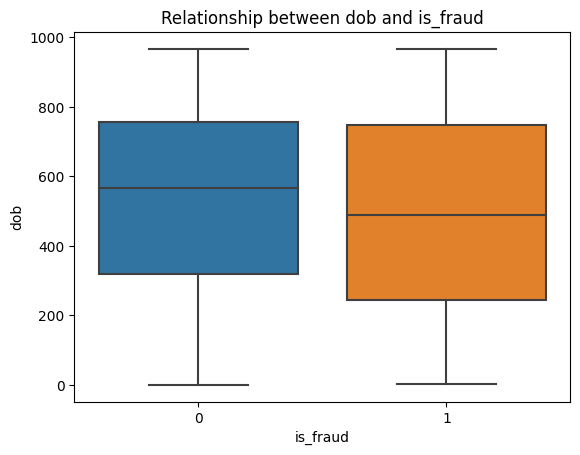

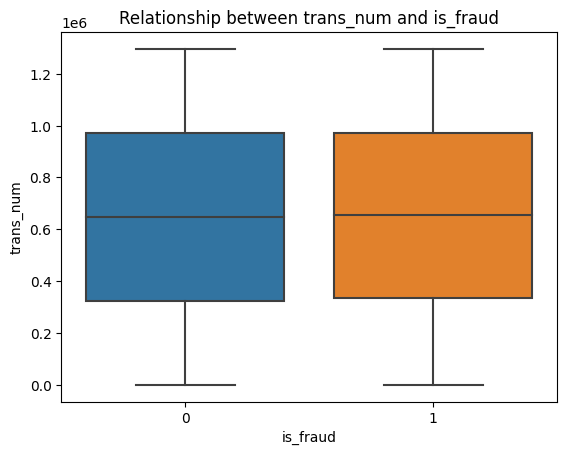

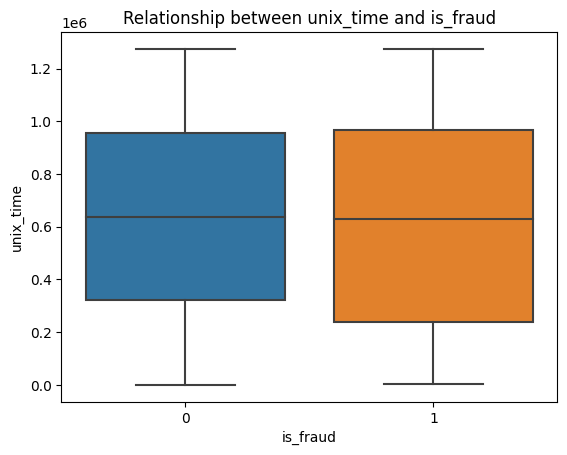

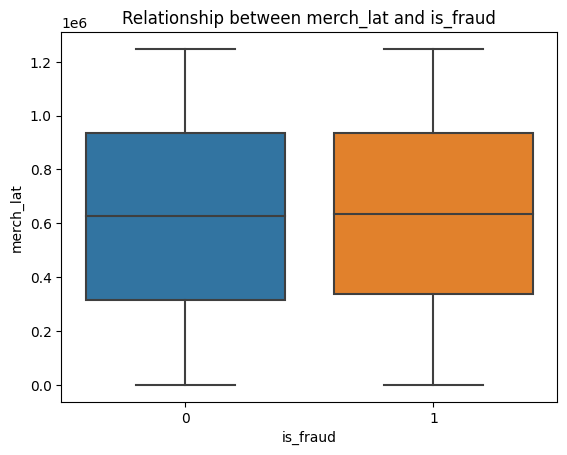

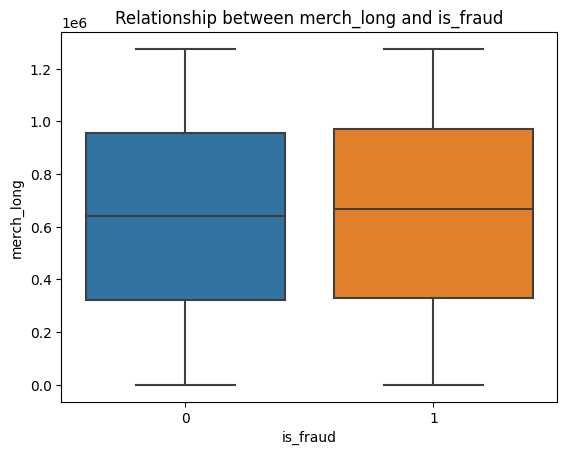

In [24]:
for col in df.columns:
    if col == 'is_fraud':
        pass
    else:
        boxplot_feature_vs_class(col,df)

In [25]:
X = df.drop(['is_fraud'],axis = 1)
y = df['is_fraud']

In [26]:
stratified_split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=42)
for train_index, test_index in stratified_split.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [27]:
smote = SMOTE(random_state=42)
# Apply SMOTE to oversample the minority class
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)

**Modelling**

**Logistic Regression**

In [28]:
lg_model = LogisticRegression(random_state=42)
lg_model.fit(X_train_oversampled, y_train_oversampled)

LogisticRegression(random_state=42)

In [29]:
lg_ypred = lg_model.predict(X_test)
print("Accuracy score is: ",round(accuracy_score(y_test, lg_ypred)*100,2),'%')

Accuracy score is:  92.41 %


In [30]:
print(classification_report(y_test, lg_ypred))
print("ROC-AUC:", roc_auc_score(y_test, lg_ypred))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    386751
           1       0.06      0.77      0.10      2252

    accuracy                           0.92    389003
   macro avg       0.53      0.85      0.53    389003
weighted avg       0.99      0.92      0.96    389003

ROC-AUC: 0.8461593899715989


In [31]:
lgconfusion_matrix = confusion_matrix(y_test, lg_ypred)

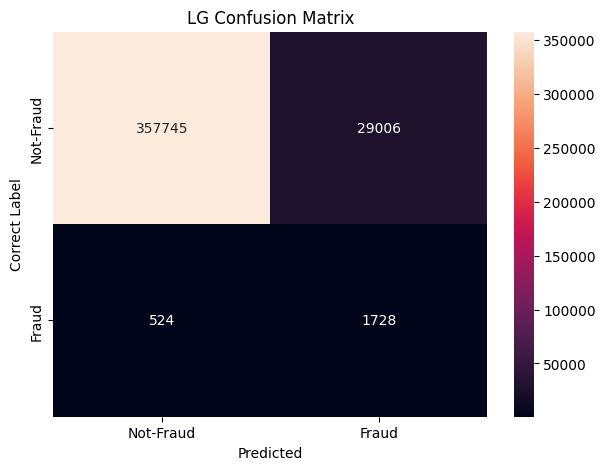

In [32]:
plt.figure(figsize=(7, 5))
plt.title('LG Confusion Matrix')
sns.heatmap(lgconfusion_matrix, annot=True, xticklabels=["Not-Fraud","Fraud"],
            yticklabels=["Not-Fraud","Fraud"], fmt='g')
plt.xlabel('Predicted')
plt.ylabel('Correct Label')
plt.show()

**DecisionTree**

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [34]:
df = pd.read_csv("/content/drive/MyDrive/Credit_Card_Fraud_Detection/fraudTrain.csv")

In [35]:
clf = DecisionTreeClassifier()

In [36]:
clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [37]:
y_pred = clf.predict(X_test)

In [38]:
print('Accuracy:', clf.score(X_test, y_test))

Accuracy: 0.9962493862515199


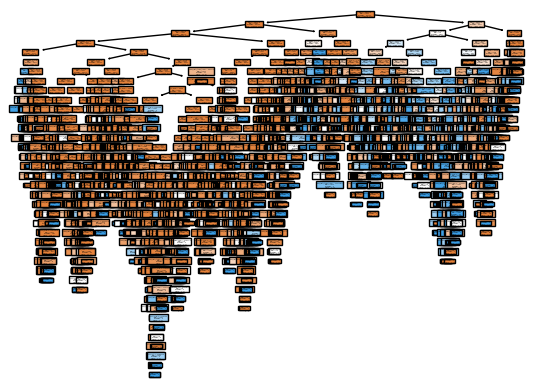

In [39]:
from sklearn.tree import plot_tree
plot_tree(clf, filled=True, feature_names=X_train.columns)
plt.show()
